# Week 8 - Linear Disciminant Analysis and Optimization

* FDA (2 classes)
    * Compute the class means (in PCA space)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection vector $\mathbf{w}$
    * Compute and plot the 1D projection of the data
    * Compute the class separation of the projected values
* LDA (3 classes)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection matrix $\mathbf{W}$
    * Compute and plot the 2D projection of the data
    * Compute the 2D LDA projection of the original 64D data 
* Constrained Optimization
    * Reformulate the problem as a maximization problem
    * Write out the Lagrangian function
    * Compute the gradients with respects to $x_1, x_2$, Lagrange multiplier $\lambda$ and the KKT multiplier $\mu$
    * Compute the optimum

In [2]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits, make_swiss_roll
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(); sns.set_palette('bright')

## Data
As usual, we'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [3]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [4]:
# Handy plotting functions

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, alpha=0.5, legend=True,w=None):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    if w is not None:
        # Define the range of x values based on the scatter plot data
        x_values = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100)
        
        # Calculate corresponding y values based on the line equation: w0 + w1*x1 + w2*x2 = 0 => x2 = -(w0 + w1*x1) / w2
        y_values = w[1] * x_values + w[0]

        # Plot the line
        plt.plot(x_values, y_values, color='red', label='Decision boundary')
    #plt.show()
    
def plot_scatter3d(data, targets, view_point=(25, 45), alpha=0.5, legend=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c=targets, cmap="rainbow", alpha=alpha)
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    ax.view_init(*view_point) # <- change viewpoint here
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

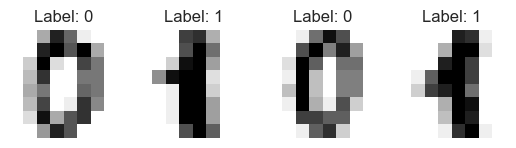

In [5]:
plot_examples()

In [6]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with
t = digits.target

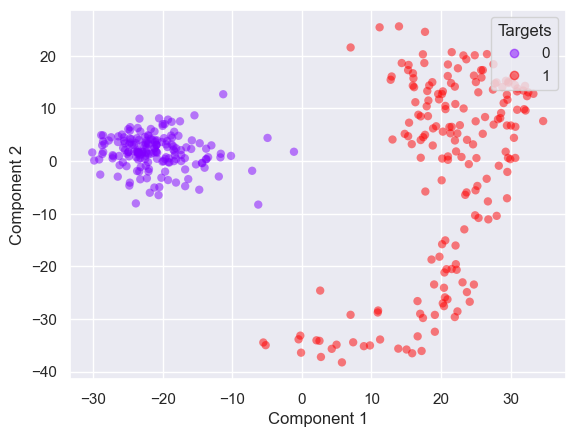

In [7]:
# Let's plot all the data in 2D
plot_scatter(X, t)

## 1) Fisher Discriminant Analysis (FDA)


### 1.1) Compute the class means (in PCA space)

Class means:
  Class 0: [-21.14447038   1.75335626]
  Class 1: [20.67975675 -1.71482096]


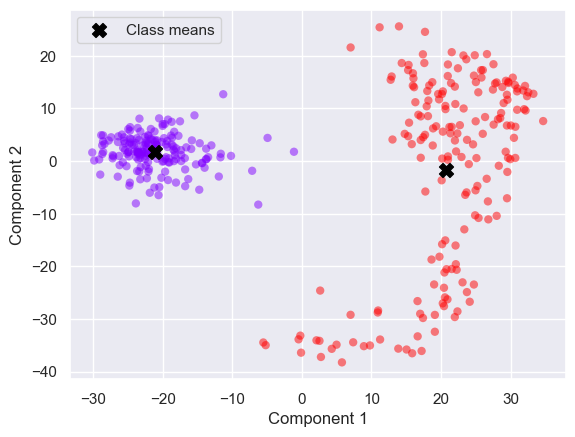

In [8]:
def class_means(X, t):
    classes = np.unique(t)
    means = []
    for c in classes:
        X_c = X[t == c]
        means.append(np.mean(X_c, axis=0))
    return np.array(means)

# Compute and print the class means
means = class_means(X, t)
print("Class means:")
for i, mean in enumerate(means):
    print(f"  Class {i}: {mean}")

# Plot the data with class means
plot_scatter(X, t, alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], c='black', s=100, marker='X', edgecolors='black', linewidths=1, label='Class means', zorder=5)
plt.legend()
plt.show()

### 1.2) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
Use eq (4.27) and (4.28) from textbook for computing $\mathbf{S}_B$ and $\mathbf{S}_W$ respectively

In [9]:
def scatter_mat_w(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    overall_mean = np.mean(X, axis=0)
    
    S_W = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[t == c]
        class_mean = np.mean(X_c, axis=0)
        S_W += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

    return S_W

def scatter_mat_b(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    
    if len(classes) == 2:
        X_0 = X[t == classes[0]]
        X_1 = X[t == classes[1]]
        mean_0 = np.mean(X_0, axis=0)
        mean_1 = np.mean(X_1, axis=0)
        mean_diff = mean_1 - mean_0
        S_B = np.outer(mean_diff, mean_diff)

    return S_B

print("Sw:", scatter_mat_w(X, t))
print("")
print("Sb:", scatter_mat_b(X, t))

Sw: [[15041.33444706 13053.23317691]
 [13053.23317691 64127.63085988]]

Sb: [[1749.26597493 -145.05383207]
 [-145.05383207   12.02825328]]


### 1.3) Compute the projection vector $\mathbf{w}$
Hint: Use eq. (4.30) from textbook. You can use `np.linalg.pinv` and `np.linalg.eig` for computing the pseudo-inverse and eigenvectors, respectively. Also, remember to ensure that $||w||_2 = 1$

In [10]:
def compute_projection_vector(X, t):
    S_W = scatter_mat_w(X, t)
    S_B = scatter_mat_b(X, t)
    
    # inv(S_W) * S_B
    eigvals, eigvecs = scipy.linalg.eig(S_B, S_W)
    
    # Get the index of the largest eigenvalue
    max_index = np.argmax(eigvals.real)
    
    # Corresponding eigenvector
    w = eigvecs[:, max_index].real
    
    # Normalize the projection vector
    w /= np.linalg.norm(w)
    
    return w

Projection vector w: [-0.97678792  0.21420868]


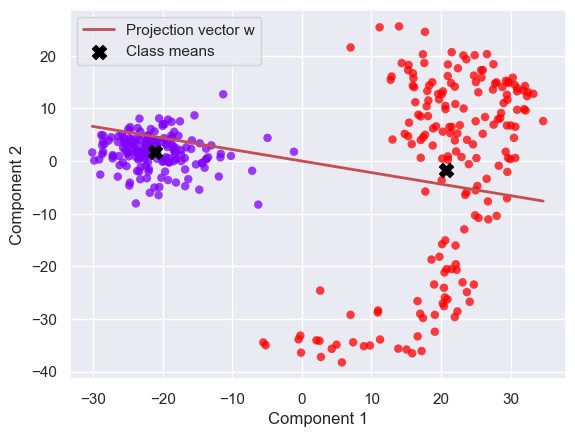

In [11]:
w = compute_projection_vector(X, t)
print("Projection vector w:", w)

plot_scatter(X, t, alpha=0.5)

origin = np.mean(X, axis=0)  

x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

y_line = origin[1] + (w[1]/w[0]) * (x_range - origin[0])
plt.plot(x_range, y_line, 'r-', linewidth=2, label='Projection vector w')


plot_scatter(X, t, alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], c='black', s=100, marker='X', edgecolors='black', linewidths=1, label='Class means', zorder=5)

plt.legend()
plt.show()

### 1.4) Compute and plot the 1D projection of the data
Hint: You can use `seaborn.displot` for a nice visualisation

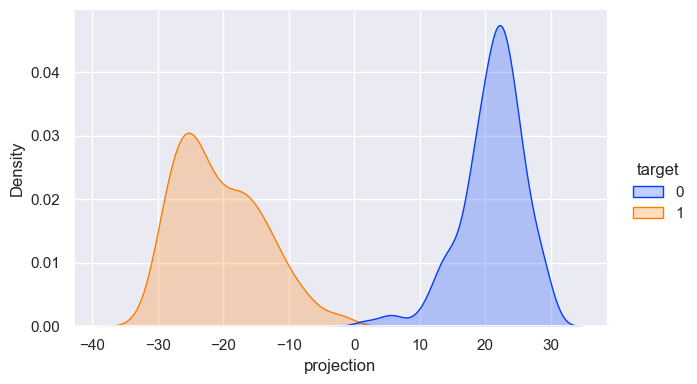

In [14]:
import pandas as pd

w = compute_projection_vector(X, t)

proj = X.dot(w)

df_proj = pd.DataFrame({'projection': proj, 'target': t})

sns.displot(df_proj, x='projection', hue='target', kind='kde', height=4, aspect=1.6, fill=True)

plt.show()

### 1.5) Compute the class separation of the projected values

In [15]:
w = compute_projection_vector(X, t)
proj = X.dot(w)

means_proj = class_means(proj.reshape(-1, 1), t)

class_separation = abs(means_proj[1] - means_proj[0])[0]

print(f"Class separation: {class_separation}")

Class separation: 41.596313499803784


## 2) Linear Discriminant Analysis (LDA)

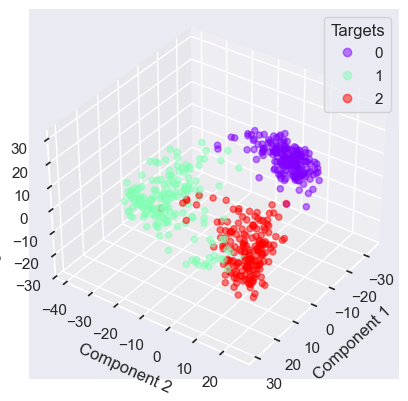

In [16]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=3)
X = pca.fit_transform(digits.data)
t = digits.target

plot_scatter3d(X, t, view_point=(35,35))

### 2.1) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
See section 4.1.6 in the textbook or Lecture 15 (slide 17)

In [17]:
def compute_scatter_mat_w(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    overall_mean = np.mean(X, axis=0)
    
    S_W = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[t == c]
        class_mean = np.mean(X_c, axis=0)
        S_W += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

    return S_W

def compute_scatter_mat_b(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    overall_mean = np.mean(X, axis=0)
    
    S_B = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[t == c]
        class_mean = np.mean(X_c, axis=0)
        n_c = X_c.shape[0]
        mean_diff = (class_mean - overall_mean).reshape(n_features, 1)
        S_B += n_c * (mean_diff).dot(mean_diff.T)

    return S_B

print("Sw:", compute_scatter_mat_w(X, t))
print("")
print("Sb:", compute_scatter_mat_b(X, t))

Sw: [[27768.47732318 19720.58431315 19025.65774766]
 [19720.58431315 51486.18362982 18774.45517105]
 [19025.65774766 18774.45517105 56959.2450652 ]]

Sb: [[168102.96379895 -19720.58431315 -19025.65774766]
 [-19720.58431315  63939.56119941 -18774.45517105]
 [-19025.65774766 -18774.45517105   9313.72203439]]


### 2.2) Compute the projection matrix $\mathbf{W}$
choose D'=2 (see lecture 15 slide 17 to understand D')

In [21]:
def compute_proj_mat_w(X, t):
    S_W = compute_scatter_mat_w(X, t)
    S_B = compute_scatter_mat_b(X, t)
    
    eigvals, eigvecs = scipy.linalg.eig(S_B, S_W)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigvals.real)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    
    return eigvals, eigvecs

eigvals, eigvecs = compute_proj_mat_w(X, t)
W = eigvecs[:, :2].real

print("Projection matrix W:")
print(W)
print()

Projection matrix W:
[[-0.91734684 -0.13270419]
 [ 0.33360306 -0.82474716]
 [ 0.21721826  0.54971058]]



### 2.3) Compute and plot the 2D projection of the data

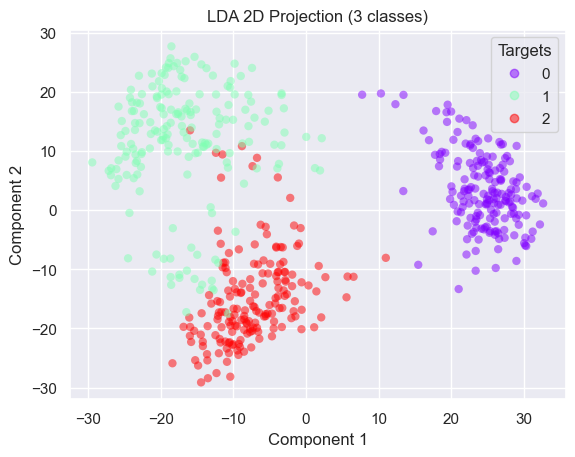

In [22]:
eigvals, eigvecs = compute_proj_mat_w(X, t)

X_projected = X @ W

plot_scatter(X_projected, t, alpha=0.5)
plt.title('LDA 2D Projection (3 classes)')
plt.show()

### 2.4) Compute and plot the 2D LDA projection of the original 64D data 

In [23]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
X = digits.data
t = digits.target

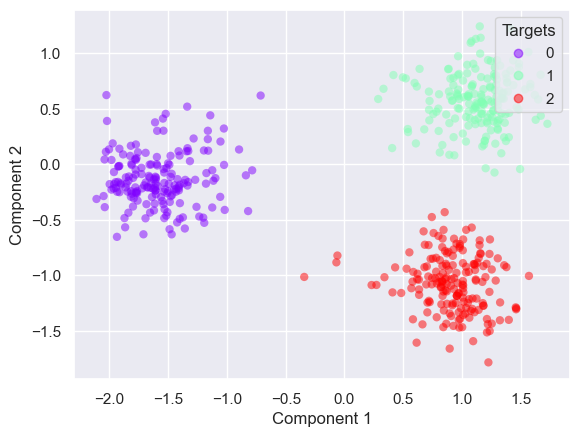

In [26]:
S_W = compute_scatter_mat_w(X, t)
S_B = compute_scatter_mat_b(X, t)

S_W_reg = S_W + 1e-6 * np.eye(S_W.shape[0])

# Compute eigenvalues and eigenvectors, sort them and select top 2 eigenvectors
eigvals, eigvecs = scipy.linalg.eig(S_B, S_W_reg)

# Sort eigenvalues and eigenvectors by real part in descending order
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

W = eigvecs[:, :2].real

# Normalize each eigenvector
W[:, 0] = W[:, 0] / np.linalg.norm(W[:, 0])
W[:, 1] = W[:, 1] / np.linalg.norm(W[:, 1])

X_projected = X @ W

plot_scatter(X_projected, t, alpha=0.5)
plt.show()


Comment on the general utility of the projection as compared to PCA

I think the utility of this projection is to see better the data since it has better clas separation thatn PCA. And since it has better class separation and it is supervised, it is also better for classification tasks.

# 3) Constrained Optimization
 
Consider the problem

minimize $f_{min}(x_1, x_2)$

subject to $ x_1 + x_2 \leq 4 
\quad \text{ and } \quad x_1 + 4x_2 = 5 
$
where $f_{min}(x_1, x_2) = (x_1 - 3)^2 + (x_2 - 2)^2$

## 3.1) Reformulate the problem as a canonical maximization problem
_Use the form described in the end of "Pattern Recognition and Machine Learning" Appendix E._

_NB: There is an error in appendix E: $h(x) \leq 0$, not $h(x) \geq 0$._

Maximize: 
$$f(x_1, x_2) = -(x_1 - 3)^2 - (x_2 - 2)^2$$

Subject to:
- Equality constraint: $g(x_1, x_2) = x_1 + 4x_2 - 5 = 0$
- Inequality constraint: $h(x_1, x_2) = x_1 + x_2 - 4 \leq 0$

## 3.2) Write out the Lagrangian function
_Use Equation (E.12) in "Pattern Recognition and Machine Learning" Appendix E., and write out all variables_

$$\mathcal{L}(x, \{\lambda_j\}, \{\mu_k\}) = f(x) + \sum_{j=1}^{J} \lambda_j g_j(x) + \sum_{k=1}^{K} \mu_k h_k(x)$$

We have:
- 1 equality constraint: $g(x_1, x_2) = x_1 + 4x_2 - 5 = 0$
- 1 inequality constraint: $h(x_1, x_2) = x_1 + x_2 - 4 \leq 0$

So the Lagrangian becomes:

$$\mathcal{L}(x_1, x_2, \lambda, \mu) = f(x_1, x_2) + \lambda g(x_1, x_2) + \mu h(x_1, x_2)$$

Substituting all functions:

$$\mathcal{L}(x_1, x_2, \lambda, \mu) = - (x_1 - 3)^2 - (x_2 - 2)^2 + \lambda(x_1 + 4x_2 - 5) + \mu(x_1 + x_2 - 4)$$

## 3.3) Compute the gradients with respects to $x_1, x_2$, lagrange multiplier $\lambda$ and the KKT multiplier $\mu$

$$\mathcal{L}(x_1, x_2, \lambda, \mu) = - (x_1 - 3)^2 - (x_2 - 2)^2 + \lambda(x_1 + 4x_2 - 5) + \mu(x_1 + x_2 - 4)$$

---

1) $x_1$:

$$\frac{\partial \mathcal{L}}{\partial x_1} = \frac{\partial f}{\partial x_1} + \lambda \cdot 1 + \mu \cdot 1$$

$$\frac{\partial \mathcal{L}}{\partial x_1} = -2(x_1 - 3) + \lambda + \mu = 0$$

---

2) $x_2$:

$$\frac{\partial \mathcal{L}}{\partial x_2} = \frac{\partial f}{\partial x_2} + \lambda \cdot 4 + \mu \cdot 1$$

$$\frac{\partial \mathcal{L}}{\partial x_2} = -2(x_2 - 2) + 4\lambda + \mu = 0$$

---

3) $\lambda$:

$$\frac{\partial \mathcal{L}}{\partial \lambda} = x_1 + 4x_2 - 5 = 0$$

($g(x_1, x_2) = 0$)

---

4) $\mu$:

$$\frac{\partial \mathcal{L}}{\partial \mu} = x_1 + x_2 - 4 = 0 \quad \text{(if active)}$$

($h(x_1, x_2) = 0$)

### 3.4) Compute the optimum
_Hint: Set it up as a system of linear equations and solve it using Gaussian Elimination (e.g. using `scipy.linalg.solve`)._

Follow these steps:

1. **Assume the inequality constraint \( h(x) \) is inactive.**  
   - Set its Lagrange multiplier to zero (\( \mu = 0 \)).  
   - Include only the equality constraint \( g(x) = 0 \) in your formulation.  
   - Construct the system of equations from the KKT conditions:  
     \[
     \nabla f(x) + \lambda \nabla g(x) = 0, \quad g(x) = 0
     \]
   - Solve for \( x_1, x_2, \lambda \) using `scipy.linalg.solve`.

2. **Check the inequality constraint.**  
   - Evaluate \( h(x_1, x_2) \).  
   - If \( h(x_1, x_2) < 0 \), the constraint is inactive — keep this as your final solution.

3. **If the inequality is violated** (\( h(x_1, x_2) > 0 \)):  
   - Reformulate the problem assuming \( h(x) \) is **active** (\( h(x) = 0 \)).  
   - Include both constraints in the Lagrangian:  
     \[
     \mathcal{L}(x_1, x_2, \lambda, \mu) = f(x_1, x_2) + \lambda g(x_1, x_2) + \mu h(x_1, x_2)
     \]
   - Construct the corresponding system of equations:
     \[
     \nabla f(x) + \lambda \nabla g(x) + \mu \nabla h(x) = 0, \quad g(x) = 0, \quad h(x) = 0
     \]
   - Solve for \( x_1, x_2, \lambda, \mu \) using `scipy.linalg.solve`.

_The correct optimum is the solution that satisfies all constraints and yields the lowest \( f(x) \)._


In [33]:
import numpy as np
from scipy.linalg import solve

# Define f, g and h
def f(x1, x2):
    return (x1 - 3)**2 + (x2 - 2)**2

def g(x1, x2):
    return x1 + 4*x2 - 5

def h(x1, x2):
    return x1 + x2 - 4

# Assume inequality constraint h(x) is INACTIVE (μ = 0)

# System of equations when μ = 0:
# -2x1 + 6 + λ = 0
# -2x2 + 4 + 4λ = 0
# x1 + 4x2 - 5 = 0

# Rearranging into matrix form Ax = b:
# -2x1 + 0x2 + λ = -6
# 0x1 - 2x2 + 4λ = -4
# x1 + 4x2 + 0λ = 5

A_inactive = np.array([
    [-2,  0,  1],
    [ 0, -2,  4],
    [ 1,  4,  0]
])

b_inactive = np.array([-6, -4, 5])

# Solve the system
solution_inactive = solve(A_inactive, b_inactive)
x1_inactive, x2_inactive, lambda_inactive = solution_inactive

print(f"\nSolution with μ = 0:")
print(f"  x1 = {x1_inactive:.4f}")
print(f"  x2 = {x2_inactive:.4f}")
print(f"  λ = {lambda_inactive:.4f}")

# Check the inequality constraint
h_value = h(x1_inactive, x2_inactive)
print(f"  h({x1_inactive:.4f}, {x2_inactive:.4f}) = {h_value:.4f}")

if h_value <= 0:
    print()
    print(f"  h(x) ≤ 0 ✓")
    print()
    x1_opt, x2_opt = x1_inactive, x2_inactive
    f_opt = f(x1_opt, x2_opt)
    print(f"  x1* = {x1_opt:.4f}")
    print(f"  x2* = {x2_opt:.4f}")
    print(f"  f(x1*, x2*) = {f_opt:.4f}")
else:
    print()
    print(f"  h(x) > 0 ✗")
    print()
    # Assume inequality constraint h(x) is ACTIVE (h = 0)
    
    # System of equations when h(x) = 0:
    # -2x1 + 6 + λ + μ = 0
    # -2x2 + 4 + 4λ + μ = 0
    # x1 + 4x2 - 5 = 0
    # x1 + x2 - 4 = 0
    
    # Rearranging into matrix form Ax = b:
    # -2x1 + 0x2 + λ + μ = -6
    # 0x1 - 2x2 + 4λ + μ = -4
    # x1 + 4x2 + 0λ + 0μ = 5
    # x1 + x2 + 0λ + 0μ = 4
    
    A_active = np.array([
        [-2,  0,  1,  1],
        [ 0, -2,  4,  1],
        [ 1,  4,  0,  0],
        [ 1,  1,  0,  0]
    ])
    
    b_active = np.array([-6, -4, 5, 4])
    
    # Solve the system
    solution_active = solve(A_active, b_active)
    x1_active, x2_active, lambda_active, mu_active = solution_active
    
    print(f"\nSolution with h(x) = 0:")
    print(f"  x1 = {x1_active:.4f}")
    print(f"  x2 = {x2_active:.4f}")
    print(f"  λ = {lambda_active:.4f}")
    print(f"  μ = {mu_active:.4f}")
    print()
    
    # Check if μ ≥ 0 (KKT condition for inequality constraint)
    print(f"\nChecking KKT condition: μ ≥ 0")
    if mu_active >= 0:
        print(f"  ✓ μ = {mu_active:.4f} ≥ 0: KKT condition satisfied")
        x1_opt, x2_opt = x1_active, x2_active
        f_opt = f(x1_opt, x2_opt)
        print()
        print(f"  x1* = {x1_opt:.4f}")
        print(f"  x2* = {x2_opt:.4f}")
        print(f"  f(x1*, x2*) = {f_opt:.4f}")
    else:
        print(f"  ✗ μ = {mu_active:.4f} < 0: KKT condition violated")
        print("  This solution is not valid.")


Solution with μ = 0:
  x1 = 2.6471
  x2 = 0.5882
  λ = -0.7059
  h(2.6471, 0.5882) = -0.7647

  h(x) ≤ 0 ✓

  x1* = 2.6471
  x2* = 0.5882
  f(x1*, x2*) = 2.1176
